### 思路
1. 数据处理，构造数据集
    - 文本：选max_vocab常见word、K个常见ans
    - 图像：
- 模型
    - image：缩放->cnn->fc_1024
    - question：embeddin->rnn->fc_1024
    - concat or add->fc_K->softmax_K->交叉熵？


In [1]:
import json
with open('./dataset/mscoco_val2014_annotations.json') as f1, open('./dataset/MultipleChoice_mscoco_val2014_questions.json') as f2:
    annotations = json.load(f1)
    questions = json.load(f2) 

# with open('./dataset/v2_mscoco_val2014_annotations.json') as f1, open('./dataset/v2_OpenEnded_mscoco_val2014_questions.json') as f2:
#     annotations = json.load(f1)
#     questions = json.load(f2) 
# with open('./dataset/OpenEnded_mscoco_val2014_questions.json') as f:
#     question = json.load(f)


[解析JSON](https://python3-cookbook.readthedocs.io/zh_CN/latest/c06/p02_read-write_json_data.html)，先观察数据

In [2]:
ques_n = 6 #取的ques数
ans_k = 1000 #最常见的ans数

官方API中vqaTools demo：

In [3]:
from vqaTool import VQA
import random
import skimage.io as io
import matplotlib.pyplot as plt
import os

dataDir		='./dataset'
versionType ='' # this should be '' when using VQA v2.0 dataset
taskType    ='MultipleChoice' # 'OpenEnded' only for v2.0. 'OpenEnded' or 'MultipleChoice' for v1.0
dataType    ='mscoco'  # 'mscoco' only for v1.0. 'mscoco' for real and 'abstract_v002' for abstract for v1.0.
dataSubType ='val2014'
annFile     ='%s/%s%s_%s_annotations.json'%(dataDir, versionType, dataType, dataSubType)
quesFile    ='%s/%s%s_%s_%s_questions.json'%(dataDir, versionType, taskType, dataType, dataSubType)
# imgDir 		= '%s/Images/%s/%s/' %(dataDir, dataType, dataSubType)
imgDir = '%s/Images/%s/' %(dataDir, dataSubType)

# initialize VQA api for QA annotations
vqa=VQA(annFile, quesFile)

# load and display QA annotations for given question types
"""
All possible quesTypes for abstract and mscoco has been provided in respective text files in ../QuestionTypes/ folder.
"""
# annIds = vqa.getQuesIds(quesTypes='how many');   
# anns = vqa.loadQA(annIds)
# randomAnn = random.choice(anns)
# vqa.showQA([randomAnn])
# imgId = randomAnn['image_id']
# imgFilename = 'COCO_' + dataSubType + '_'+ str(imgId).zfill(12) + '.jpg'
# if os.path.isfile(imgDir + imgFilename):
# 	I = io.imread(imgDir + imgFilename)
# 	plt.imshow(I)
# 	plt.axis('off')
# 	plt.show()

# load and display QA annotations for given answer types
"""
ansTypes can be one of the following
yes/no
number
other
"""
# annIds = vqa.getQuesIds(ansTypes='yes/no');   
# anns = vqa.loadQA(annIds)
# randomAnn = random.choice(anns)
# vqa.showQA([randomAnn])
# imgId = randomAnn['image_id']
# imgFilename = 'COCO_' + dataSubType + '_'+ str(imgId).zfill(12) + '.jpg'
# if os.path.isfile(imgDir + imgFilename):
# 	I = io.imread(imgDir + imgFilename)
# 	plt.imshow(I)
# 	plt.axis('off')
# 	plt.show()

# load and display QA annotations for given images
"""
Usage: vqa.getImgIds(quesIds=[], quesTypes=[], ansTypes=[])
Above method can be used to retrieve imageIds for given question Ids or given question types or given answer types.
"""
# ids = vqa.getImgIds()
# print(len(ids))


# annIds = vqa.getQuesIds(imgIds=random.sample(ids,5))
# print('id',annIds)
# anns = vqa.loadQA(annIds)
# randomAnn = random.choice(anns)
# vqa.showQA([randomAnn])  
# imgId = randomAnn['image_id']
# imgFilename = 'COCO_' + dataSubType + '_'+ str(imgId).zfill(12) + '.jpg'
# if os.path.isfile(imgDir + imgFilename):
# 	I = io.imread(imgDir + imgFilename)
# 	plt.imshow(I)
# 	plt.axis('off')
# 	plt.show()

loading VQA annotations and questions into memory...
0:00:04.973586
creating index...
index created!


'\nUsage: vqa.getImgIds(quesIds=[], quesTypes=[], ansTypes=[])\nAbove method can be used to retrieve imageIds for given question Ids or given question types or given answer types.\n'

In [4]:
ans = annotations['annotations']
ques = questions['questions']
len(ans), len(ques)

(121512, 121512)

In [6]:
display(ans[5])
print()
display(ques[5])

{'answer_type': 'other',
 'answers': [{'answer': 'tree', 'answer_confidence': 'yes', 'answer_id': 1},
  {'answer': 'tree', 'answer_confidence': 'yes', 'answer_id': 2},
  {'answer': 'tree', 'answer_confidence': 'yes', 'answer_id': 3},
  {'answer': 'tree', 'answer_confidence': 'yes', 'answer_id': 4},
  {'answer': 'tree', 'answer_confidence': 'yes', 'answer_id': 5},
  {'answer': 'tree', 'answer_confidence': 'yes', 'answer_id': 6},
  {'answer': 'tree', 'answer_confidence': 'yes', 'answer_id': 7},
  {'answer': 'tree', 'answer_confidence': 'yes', 'answer_id': 8},
  {'answer': 'tree', 'answer_confidence': 'yes', 'answer_id': 9},
  {'answer': 'tree', 'answer_confidence': 'yes', 'answer_id': 10}],
 'image_id': 8647,
 'multiple_choice_answer': 'tree',
 'question_id': 86471,
 'question_type': 'what is in the'}

{'image_id': 8647,
 'multiple_choices': ['red',
  '4',
  '2',
  '1',
  'berries and cake',
  'light',
  'no',
  'sun',
  'white',
  'yes',
  'green',
  '1.50',
  'mayonnaise',
  '3',
  'blue',
  'tree',
  'stamp',
  'on feet'],
 'question': 'What is in the top right corner?',
 'question_id': 86471}

### 构造数据集
**处理文本**

In [9]:
ground_truth_trainset = []
ques_trainset = []
img_ids = []

for i in range(ques_n):
    ground_truth_trainset.append(ans[i]['multiple_choice_answer'])
    ques_trainset.append(ques[i]['question'])
    if i % 3 == 0:
        img_ids.append(ques[i]['image_id'])
print(ground_truth_trainset, ques_trainset, img_ids, sep='\n\n')

#构建词表与ans表


['wood', 'no', 'kettles', 'no', 'yes', 'tree']

['What is the table made of?', 'Is the food napping on the table?', 'What has been upcycled to make lights?', 'Is this an Spanish town?', 'Are there shadows on the sidewalk?', 'What is in the top right corner?']

[350623, 8647]


** 处理图像 **

C:\Users\Administrator\Anaconda3\lib\site-packages\torchvision\transforms\transforms.py:209: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")


<class 'torch.Tensor'> torch.Size([3, 256, 256])


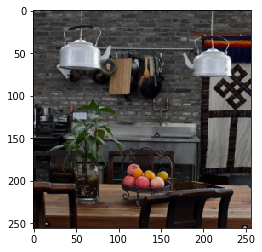

<class 'torch.Tensor'> torch.Size([3, 256, 256])


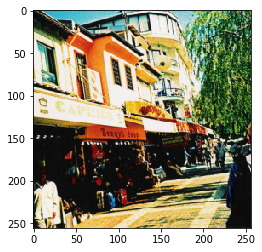

In [21]:
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

def readImage(path, size=256):
    mode = Image.open(path)
    transform1 = transforms.Compose([
        transforms.Scale(size),
        transforms.CenterCrop((size, size)),
        transforms.ToTensor()
    ])
    mode = transform1(mode)
    return mode

def showTorchImage(image):
    mode = transforms.ToPILImage()(image)
    plt.imshow(mode)
    plt.show()

for img_id in img_ids[:2]:
    img_filename = 'COCO_' + dataSubType + '_'+ str(img_id).zfill(12) + '.jpg'
#     img_mode = readImage(imgDir + img_filename)
    img_mode = readImage('dataset/Images/' + img_filename)
    print(type(img_mode), img_mode.shape)
    showTorchImage(img_mode)

### VQA model

In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim

In [ ]:
class vqa_baseline(nn.Module):
    def __init__(self):
        super(vqa_baseline).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5,
                              stride=1, padding=0,)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, 
                                 padding=0)
        self.fc1 = nn.Linear(in_features=16*5*5, out_features=120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)